In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [2]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [3]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p,u,TF_fun):
        # print(p)
        # assert False    

    # Parameters
    EL222Pars, commonPars, ampPars, invertPars = p
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = EL222Pars
    kdegPPDC, Ks, Y, KI_PDC, nI_PDC = commonPars
    mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp = ampPars
    mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert = invertPars

    x_guess = x
    global setpoint

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    S = np.max(S,0)
    Enz_invert = np.max((Enz_invert,0))
    Enz_amp = np.max((Enz_amp,0))
    Rep = np.max((Rep,0))
    Amp = np.max((Amp,0))

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert ** nI_PDC + 1e-10))
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp ** nI_PDC + 1e-10))

    TF = TF_fun(u)
    mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR

    dmRNA_invert_dt = (mRNAsetpoint - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNAsetpoint - mRNA_amp) / tau_mRNA

    
    dRepdt = k_trans_Rep * mRNA_invert * S / (Ks + S) - (kdeg_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = k_trans_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert

    
    dAmpdt = k_trans_Amp * mRNA_amp * S / (Ks + S) - (kdeg_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = k_trans_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp
    dX_invert_dt = mu_x_invert * X_invert
    dX_amp_dt = mu_x_amp * X_amp

    # names = ['mRNA_invert', 'mRNA_amp', 'Rep', 'Amp', 'Enz_invert', 'Enz_amp', 'S', 'X_invert', 'X_amp']
    # for var, name in zip([mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp], names):
    #     if var<0:
    #         print('BIOOPY', name)
    #         assert False



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [4]:
from tqdm import tqdm
from scipy.interpolate import interp1d

run = True
if run:
    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr = np.zeros(u_arr.size)
    TF_arr = np.zeros(u_arr.size)

    setpoint = None
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        out = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
        mRNA_arr[i] = out[1]
        TF_arr[i] = out[0]

mRNA_fun = interp1d(u_arr, mRNA_arr, kind='cubic')
TF_fun = interp1d(u_arr, TF_arr, kind='cubic')


100%|██████████| 101/101 [02:19<00:00,  1.38s/it]


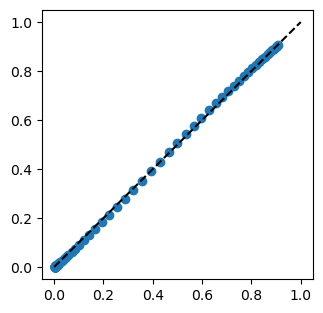

In [5]:
# dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA
mRNA_arr_myownss = kbasal_scaled + kmax_scaled * (TF_arr ** n) / ((Kd_scaled ** n) + (TF_arr ** n)) / kdegR

fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)
ax.scatter(mRNA_arr, mRNA_arr_myownss, label='mRNA steady state')
ax.plot([0,1],[0,1], color='black', linestyle='--')

In [6]:
# assert False

# EL222 Parameters
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

# Common Parameters
# kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 0.05
Y = 0.5
nI_PDC = 2
KI_PDC = 1
commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 2 / np.log(2) * 60
K_Rep = 0.01
n_Rep = 0.7
mu_max_invert = 1
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 10
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) * 1
invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 2 / np.log(2) * 60
K_Amp = 0.4
mu_max_amp = 1.
n_Amp = 0.8
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5
ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p = EL222Pars, commonPars, ampPars, invertPars

guesses = ([1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0], [1, 1, 1, 1])

print(EL222Pars)
print(commonPars)
print(invertPars)
print(ampPars)

if True:
    lastsol = [1, 1, 1, 1]
    steady_state = []
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        def rootfunc(x):
            S = 2
            X_invert = 0.01
            X_amp = 0.01
            TF = TF_fun(u)
            # print(u,TF)
            # assert False
            mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR
            mRNA_invert = mRNAsetpoint
            mRNA_amp = mRNAsetpoint
            Rep, Amp, Enz_invert, Enz_amp = x
            x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
            return opto_growth(0,x_in,p, u, TF_fun)[2:-3]
        output = root(rootfunc, lastsol, tol=1e-10, method='hybr')
        if output.success is False:
            for i in range(4):
                guess = guesses[i]
                output = root(rootfunc, guess, tol=1e-10, method='hybr')
                if output.success:
                    lastsol = output.x
                    break
            if output.success is False:
                for i in range(100):
                    guess = np.random.uniform(0,1,4)
                    output = root(rootfunc, guess, tol=1e-10, method='hybr')
                    if output.success:
                        lastsol = output.x
                        break
            steady_state.append(output.x)
        else:
            lastsol = output.x
            steady_state.append(output.x)
    steady_state = np.array(steady_state)

(4.768121420056406, 0.34393, 8.080360096723108e-05, 0.04203519639903277, 4.203, 0.478375, 0.042116)
(1038.7404294400537, 0.05, 0.5, 1, 2)
(1, 1741.2340490667561, 173.1234049066756, 0.01, 0.7, 1039.7404294400537)
(1.0, 174.1234049066756, 173.1234049066756, 0.4, 0.8, 5198.702147200269)


100%|██████████| 101/101 [00:00<00:00, 536.27it/s]


In [7]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

In [8]:
amp_data = np.array([0.120837503, 0.123422835, 0.180854158, 0.19976335, 0.212471916, 0.262908006, 0.265834766, 0.308231875, 0.300134524, 0.307690564, 0.349198597, 0.235627624, 0.328256455, 0.256070133, 0.271335288, 0.18874746, 0.170414488, 0.133141302])
amp_lights = np.array([1, 1, 3, 3, 6, 6, 8, 8, 10, 10, 10, 20, 20, 40, 40, 70, 70, 100]) / 100

invert_data = np.array([0.259118174, 0.249223514, 0.251594487, 0.163109986, 0.116035613, 0.071939681, 0.064949075, 0.089238774, 0.08784264, 1E-10, 0.0414111, 0.040288699, 0.033536204])
invert_lights = np. array([0, 0, 1, 1.667, 1.667, 5, 5, 5, 5, 100, 100, 100, 100])/100

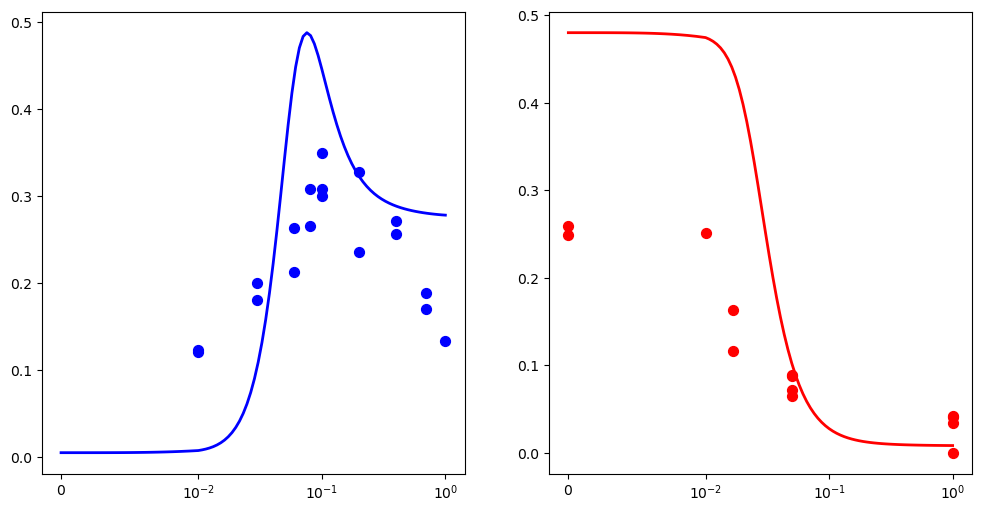

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [10]:
# assert False

In [96]:
def makessDoseRespCurve(p, u_input, TF_fun, Ks=1):
    kdegPPDC = 12 / np.log(2) * 60
    kdegR = 0.042116
    kdeg_Rep = 2 / np.log(2) * 60
    kdeg_Amp = 2 / np.log(2) * 60
    Y = 0.5
    # Ks = 1
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp = p

    EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR
    commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC
    invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert
    ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp
    p_in = EL222Pars, commonPars, ampPars, invertPars

    # print(EL222Pars)
    # print(commonPars)
    # print(ampPars)
    # print(invertPars)
    # assert False

    lastsol = [1, 1, 1, 1]
    steady_state = []
    for i, u in enumerate(u_input):
        def rootfunc(x):
            S = 2
            X_invert = 0.01
            X_amp = 0.01
            TF = TF_fun(u)
            # print(u,TF)
            # assert False
            mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR
            mRNA_invert = mRNAsetpoint
            mRNA_amp = mRNAsetpoint
            Rep, Amp, Enz_invert, Enz_amp = x
            x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
            return opto_growth(0,x_in,p_in, u, TF_fun)[2:-3]
        output = root(rootfunc, lastsol, tol=1e-10, method='hybr')
        if output.success is False:
            for i in range(4):
                guess = guesses[i]
                output = root(rootfunc, guess, tol=1e-10, method='hybr')
                if output.success:
                    lastsol = output.x
                    break
            if output.success is False:
                for i in range(100):
                    guess = np.random.uniform(0,1,4)
                    output = root(rootfunc, guess, tol=1e-10, method='hybr')
                    if output.success:
                        lastsol = output.x
                        break
            steady_state.append(output.x)
        else:
            lastsol = output.x
            steady_state.append(output.x)
    steady_state = np.array(steady_state)
    return steady_state

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x

In [49]:
# EL222 Parameters
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

# k_alpha = 4.59274930e+01
# k_beta = 1.39925875e+00
kbasal_scaled = 9.60772093e-05
kmax_scaled = 4.49896402e-02
n = 1.78509721e+00
Kd_scaled = 9.99975063e+00

EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

# Common Parameters
# kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 1
Y = 0.5
nI_PDC = 2
KI_PDC = 1

KI_PDC = 0.894579641
nI_PDC = 10.0328925

commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 2 / np.log(2) * 60
K_Rep = 0.01
n_Rep = 0.7
mu_max_invert = 1
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 10
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) * 1

mu_max_invert = 1.29586951
k_trans_Rep = 16344.2641
K_Rep = 0.00638750128
n_Rep = 0.721581267
k_trans_PDC_invert = 904.015902

invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 2 / np.log(2) * 60
K_Amp = 0.4
mu_max_amp = 1.
n_Amp = 0.8
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5

mu_max_amp = 0.793367928
k_trans_Amp = 605.394164
K_Amp = 0.686349513
n_Amp = 0.386036936
k_trans_PDC_amp = 6825.44686

ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p = EL222Pars, commonPars, ampPars, invertPars

orig_pars =  k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p_guess = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp
bounds = (0, np.inf)



steady_state  = makessDoseRespCurve(p_guess, u_arr, TF_fun)

In [50]:
k_trans_PDC_amp

6825.44686

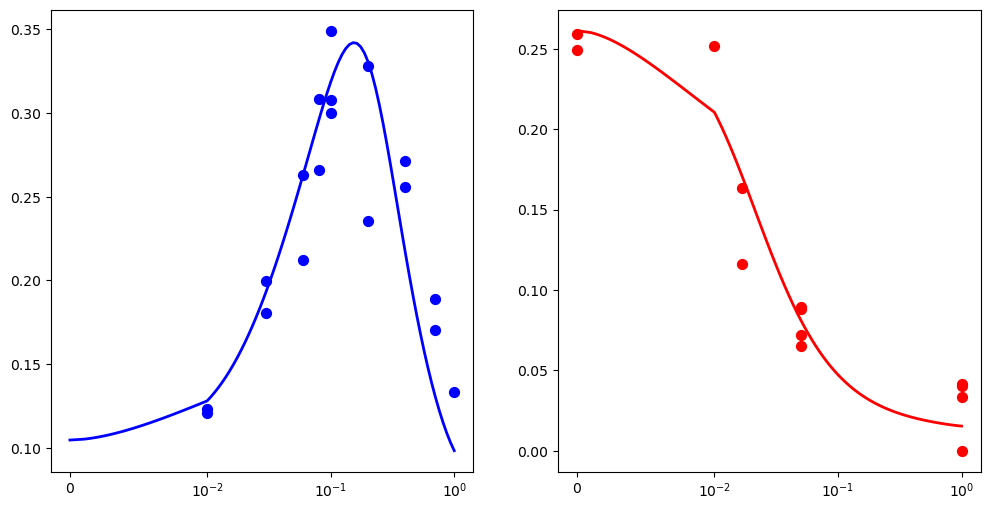

In [51]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [90]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize

def fsolve_fun(x_in, u_vals, TF_fun, info): 
    x = 10 ** np.array(x_in)
    Ks = 1
    output_states = makessDoseRespCurve(x, u_vals, TF_fun, Ks)
    _, _, Enz_invert_ss, Enz_amp_ss = output_states.T
    _, _, _, _, _, _, KI_PDC, nI_PDC, mu_max_invert, _, _, _, _, mu_max_amp, _, _, _, _ = x
    mu_amp = mu_max_amp * Enz_amp_ss * 2 / (0.1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
    mu_invert = mu_max_invert * Enz_invert_ss * 2 / (0.1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

    amp_error = 0
    inv_error = 0
    for i, u in enumerate(u_vals):
        if any(amp_lights == u):
            amp_error += np.sqrt(np.mean((mu_amp[i] - amp_data[amp_lights == u]) ** 2))
        if any(invert_lights == u):
            inv_error += np.sqrt(np.mean((mu_invert[i] - invert_data[invert_lights == u]) ** 2))

    # error = np.sqrt(amp_error**2 + inv_error ** 2)
    error = amp_error + inv_error

    if error < info['best_error']:
        info['best_error'] = error
        info['best_pars'] = x_in
        # assert False

    if info['Nfeval']%100 == 0:
        print('Nfeval: ', info['Nfeval'], 'AmpError', amp_error, 'InvError', inv_error, 'CurrentError', error, 'BestError: ', info['best_error'])
    info['Nfeval'] += 1

    return error

In [91]:
# EL222 Parameters
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kdegR = 0.042116
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
ktrans = 1.4514
kdegP = 0.007

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

# Common Parameters
kdegPPDC = 12 / np.log(2) * 60
Ks = 1.
Y = 0.5
nI_PDC = 2
KI_PDC = 1
commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 12 / np.log(2) * 60
K_Rep = 0.01
n_Rep = 0.7
mu_max_invert = 1
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 10 #/ kdeg_Rep
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) * 1 #/ kdegPPDC
invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 12 / np.log(2) * 60
K_Amp = 0.4
mu_max_amp = 1.
n_Amp = 0.8
k_trans_Amp = (mu_max_amp + kdeg_Amp) #/ kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5 #/ kdegPPDC
ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

orig_pars =  k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp

u_vals = np.unique(np.concatenate((amp_lights, invert_lights)))
p_guess = np.array([k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp])
p_guess = np.log10(p_guess)
# bounds = ((0,10), # KI_PDC
#           (0.1,10), # nI_PDC
#           (0.1,10), # mu_max_invert
#           (0.1,10), # k_trans_Rep
#           (0.1,10), # K_Rep
#           (0.1,10), # n_Rep
#           (0.1,10), # k_trans_PDC_invert
#           (0.1,10), # mu_max_amp
#           (0.1,10), # k_trans_Amp
#           (0.1,10), # K_Amp
#           (0.1,10), # n_Amp
#           (0.1,10), # k_trans_PDC_amp
#         )
bounds = ((-1,2), # k_alpha
          (-1,2), # k_beta
          (-5,0), # kbasal_scaled
          (-3,0), # kmax_scaled
          (-1,1), # n
          (-1,2), # Kd_scaled
          (-1,1), # KI_PDC
          (0,2),  # nI_PDC
          (-1,1), # mu_max_invert
          (1,5), # k_trans_Rep ###
          (-3,1), # K_Rep   ###
          (-2,1), # n_Rep
          (2,5), # k_trans_PDC_invert
          (-1,1), # mu_max_amp
          (1,5), # k_trans_Amp
          (-2,1), # K_Amp
          (-2,1), # n_Amp
          (2,5), # k_trans_PDC_amp
        )

lower_bounds = [b[0] for b in bounds]
upper_bounds = [b[1] for b in bounds]

print(p_guess > lower_bounds)
print(p_guess < upper_bounds)
print(k_trans_PDC_amp)
print(k_trans_Amp)
print(k_trans_PDC_invert)
print(k_trans_Rep)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
5198.702147200269
1039.7404294400537
1039.7404294400537
10397.404294400538


In [92]:
print(len(bounds))
print(p_guess.shape)

18
(18,)


In [93]:
p_guess = np.array([ 1.66207274,  0.14589803, -4.01737962, -1.34688748,  0.25166187,  0.99998917,
 -0.04838099,  1.00142616,  0.11256127,  4.21336537, -2.194669,   -0.14171475,
  2.95617607, -0.10052536,  2.78203823, -0.16345467, -0.41337114,  3.83413109])

In [94]:
import scipy.optimize

# p_guess = info['best_pars'] 
info = {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}

# sol = minimize(fsolve_fun, p_guess, args=(u_vals,TF_fun,info,), method='Powell', options={'maxiter': 1000, 'maxfev': 1000}, bounds=bounds)
sol = scipy.optimize.dual_annealing(fsolve_fun, bounds, args=(u_vals,TF_fun,info,), maxiter=10000, seed=0, x0=p_guess, no_local_search=False, minimizer_kwargs={'method':'Powell', 'bounds':bounds})
# sol = scipy.optimize.differential_evolution(fsolve_fun, bounds, args=(u_vals,TF_fun,info,), maxiter=10000, seed=0, popsize=10, tol=0.01, mutation=(0.5, 1), recombination=0.7, updating='deferred', workers=-1, polish=True, init='latinhypercube', atol=0)
# sol = scipy.optimize.basinhopping(fsolve_fun, p_guess, minimizer_kwargs={'args':(u_vals,TF_fun,info,), 'method':'Powell', 'bounds':bounds}, niter=10000, T=0.5, stepsize=0.5, interval=50)
print(sol.x)
print(sol.success)
print(sol.message)

Nfeval:  0 AmpError 0.9495789524962317 InvError 0.410235022029506 CurrentError 1.3598139745257378 BestError:  1.3598139745257378
Nfeval:  100 AmpError 1.1029604390074277 InvError 0.13213921879175905 CurrentError 1.2350996577991866 BestError:  1.1957800019452407


/tmp/ipykernel_1885566/88543052.py:10: RuntimeWarning: invalid value encountered in power
  mu_amp = mu_max_amp * Enz_amp_ss * 2 / (0.1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
/tmp/ipykernel_1885566/88543052.py:11: RuntimeWarning: invalid value encountered in power
  mu_invert = mu_max_invert * Enz_invert_ss * 2 / (0.1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))


Nfeval:  200 AmpError 0.606007998656833 InvError 0.3529825547720108 CurrentError 0.9589905534288438 BestError:  0.9589905534288438
Nfeval:  300 AmpError 0.8949757953707307 InvError 0.3477008450501909 CurrentError 1.2426766404209215 BestError:  0.8405803031655206
Nfeval:  400 AmpError 0.5567678573832142 InvError 0.3223919694667504 CurrentError 0.8791598268499646 BestError:  0.8212892530386348
Nfeval:  500 AmpError 0.47198675648363186 InvError 0.4235276087547609 CurrentError 0.8955143652383928 BestError:  0.8047885481441139


/tmp/ipykernel_1885566/2602466646.py:137: RuntimeWarning: overflow encountered in double_scalars
  mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert ** nI_PDC + 1e-10))
/tmp/ipykernel_1885566/2602466646.py:138: RuntimeWarning: overflow encountered in double_scalars
  mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp ** nI_PDC + 1e-10))


Nfeval:  600 AmpError 2.021735980951233 InvError 0.6406538781723501 CurrentError 2.662389859123583 BestError:  0.8047885481441139
Nfeval:  700 AmpError 0.7305106049491648 InvError 0.5787962867290469 CurrentError 1.3093068916782116 BestError:  0.8047885481441139
Nfeval:  800 AmpError 2.0162549397043668 InvError 0.7513364579670723 CurrentError 2.7675913976714392 BestError:  0.8047885481441139
Nfeval:  900 AmpError 2.021076046997106 InvError 0.7599320493594308 CurrentError 2.781008096356537 BestError:  0.8047885481441139


KeyboardInterrupt: 

In [ ]:
print(info)
# print(sol.x)

{'Nfeval': 3296, 'best_error': 0.2976010263395108, 'best_pars': array([ 1.99808507,  1.99928015, -4.70403039, -2.02145841,  0.24940268,
        1.00970832, -0.05090171,  0.97277723, -0.21002087,  4.45014782,
       -2.20458915, -0.01435324,  3.09376181, -0.08697834,  2.79903705,
       -0.15769042, -0.41878567,  3.83585522])}


In [ ]:
print(fsolve_fun(np.log10(orig_pars), u_vals, TF_fun, {'Nfeval':0, 'best_error':0, 'best_pars':p_guess}), orig_pars)
# print(fsolve_fun(sol.x, u_vals, mRNA_fun, {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}), sol.x)
print('======================================')
print(fsolve_fun(info['best_pars'], u_vals, TF_fun, {'Nfeval':0, 'best_error':0, 'best_pars':p_guess}), info['best_pars'])

Nfeval:  0 AmpError 0.680426017882785 InvError 0.21272773376611082 CurrentError 0.8931537516488959 BestError:  0
0.8931537516488959 (4.768121420056406, 0.34393, 8.080360096723108e-05, 0.04203519639903277, 4.203, 0.478375, 1, 2, 1, 10397.404294400538, 0.01, 0.7, 1039.7404294400537, 1.0, 1039.7404294400537, 0.4, 0.8, 5198.702147200269)
Nfeval:  0 AmpError 0.18424731527256483 InvError 0.11335371106694594 CurrentError 0.2976010263395108 BestError:  0
0.2976010263395108 [ 1.99808507  1.99928015 -4.70403039 -2.02145841  0.24940268  1.00970832
 -0.05090171  0.97277723 -0.21002087  4.45014782 -2.20458915 -0.01435324
  3.09376181 -0.08697834  2.79903705 -0.15769042 -0.41878567  3.83585522]


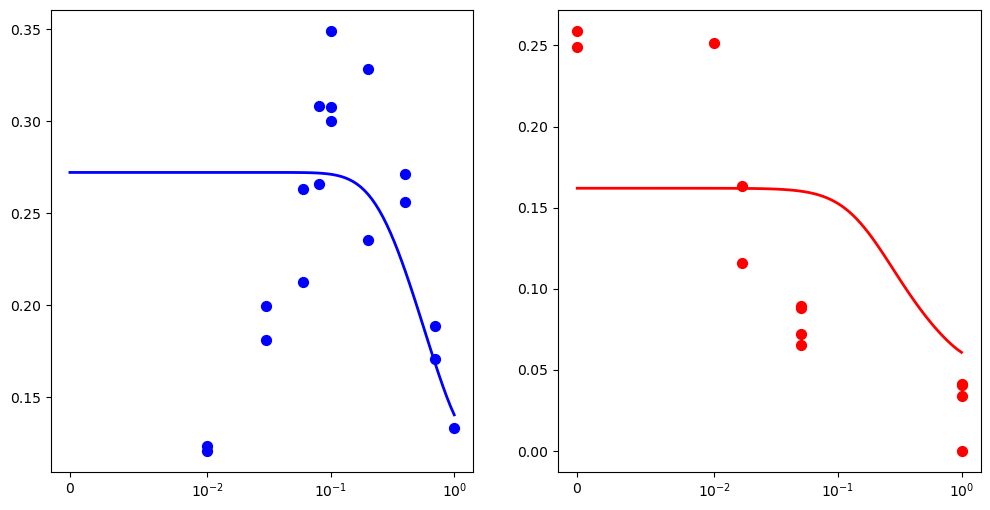

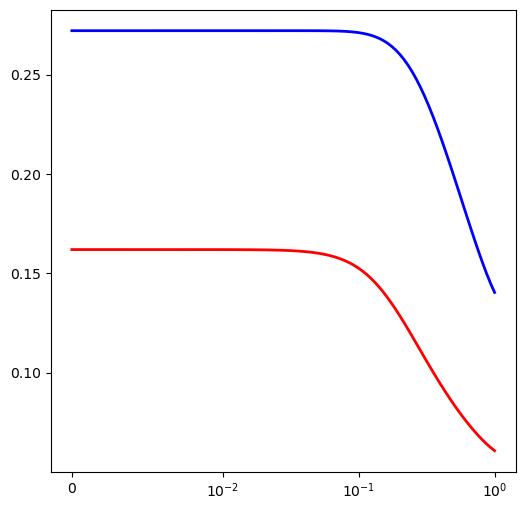

In [95]:
parstouse = 10 ** info['best_pars']
utouse = u_arr

output_states = makessDoseRespCurve(parstouse, utouse, TF_fun)
_, _, Enz_invert_ss, Enz_amp_ss = output_states.T
_, _, _, _, _, _, KI_PDC, nI_PDC, mu_max_invert, _, _, _, _, mu_max_amp, _, _, _, _ = parstouse
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(utouse, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(utouse, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(utouse, mu_invert, label='Invert', color='red', linewidth=2)
ax.plot(utouse, mu_amp, label='Amp', color='blue', linewidth=2)
ax.set_xscale('symlog', linthresh=0.01)


In [ ]:
parstouse

array([9.95600408e+01, 9.98343850e+01, 1.97683129e-05, 9.51790984e-03,
       1.77583530e+00, 1.02260595e+01, 8.89402396e-01, 9.39241408e+00,
       6.16565366e-01, 2.81934238e+04, 6.24325175e-03, 9.67490618e-01,
       1.24097151e+03, 8.18505602e-01, 6.29559885e+02, 6.95519931e-01,
       3.81253932e-01, 6.85259741e+03])